#<font color="green"> Part A: IMDb Movie Review Sentiment Analysis

## ⚛Data Exploration and Preprocessing

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk

In [ ]:
# From nltk.corpus, we import stopwords to get a list of common English stop words.
from nltk.corpus import stopwords
# From nltk.stem, we import WordNetLemmatizer for lemmatization.
from nltk.stem import WordNetLemmatizer


In [ ]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
#Loading dataset
imdb_df=pd.read_csv("/content/drive/MyDrive/Imdb_data.csv")

In [ ]:
imdb_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
#checking null values
print("\n Missing values:")
imdb_df.isnull().sum()


 Missing values:


,0
review,0
sentiment,0


In [ ]:
#checking distribution of sentiments
print("\nSentiment Distribution")
imdb_df['sentiment'].value_counts()


Sentiment Distribution


,count
sentiment,
positive,25000
negative,25000


In [ ]:
imdb_df['review_length']=imdb_df['review'].apply(len)
print("\nReview length")
print(imdb_df['review_length'].describe())


Review length
count    50000.000000
mean      1309.367720
std        989.759532
min          7.000000
25%        699.000000
50%        970.000000
75%       1590.000000
max      13704.000000
Name: review_length, dtype: float64


In [ ]:
# Initialize the lemmatizer, which converts words to their base form.
lemmatizer = WordNetLemmatizer()
# Create a set of English stop words for quick lookups.
stop_words = set(stopwords.words('english'))

In [ ]:
def preprocess_text(text):
    # Lowercasing: Convert all text to lowercase to ensure consistency.
    text = text.lower()

    #  Remove HTML tags: HTML tags like '<br />' are common in web-scraped data.
    # This regex finds anything between '<' and '>' and replaces it with an empty string.
    text = re.sub(r'<.*?>', '', text)

    #  Remove punctuation: Replace common punctuation marks with a space.
    # This regex replaces any character that is not a word character or a whitespace character.
    text = re.sub(r'[^\w\s]', '', text)

    #  Remove special characters and numbers: Keep only alphabetic characters and spaces.
    # This regex replaces anything that is not an alphabet or a space.
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization: Split the text into individual words (tokens).
    words = nltk.word_tokenize(text)

    # Remove stop words and Lemmatization:
    # Filter out stop words and then convert each word to its base form.
    processed_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    # Join the processed words back into a single string, separated by spaces.
    return ' '.join(processed_words)

In [ ]:
# Applying the preprocessing function to the 'review' column.
imdb_df['cleaned_review'] = imdb_df['review'].apply(preprocess_text)  #creates a new column in the dataset


In [ ]:
imdb_df[['review','cleaned_review']].head()

,review,cleaned_review
0,One of the other reviewers has mentioned that ...,one reviewer mentioned watching oz episode you...
1,A wonderful little production. <br /><br />The...,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,basically there family little boy jake think t...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter matteis love time money visually stunni...


##⚛Feature Engineering

In [ ]:
#Feature Engineering(converts cleaned text into numerical features and add other textual features)
#Word_count : number of words in the cleaned review
imdb_df['word_count']=imdb_df['cleaned_review'].apply(lambda x:len(x.split()))
# Character Count: Number of non-space characters.
imdb_df['char_count'] = imdb_df['cleaned_review'].apply(lambda x: len(x.replace(" ", "")))
# Average Word Length: Total characters divided by word count
imdb_df['avg_word_length'] = imdb_df['char_count'] / imdb_df['word_count'].replace(0, 1) # Replace 0 with 1 to avoid division by zero



In [ ]:
print("\nTextual Features Added")
imdb_df[['review', 'cleaned_review', 'word_count', 'char_count', 'avg_word_length']].head()




Textual Features Added


,review,cleaned_review,word_count,char_count,avg_word_length
0,One of the other reviewers has mentioned that ...,one reviewer mentioned watching oz episode you...,167,959,5.742515
1,A wonderful little production. <br /><br />The...,wonderful little production filming technique ...,84,557,6.630952
2,I thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...,85,496,5.835294
3,Basically there's a family where a little boy ...,basically there family little boy jake think t...,66,381,5.772727
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter matteis love time money visually stunni...,125,727,5.816000


In [ ]:
 # TF-IDF (Term Frequency-Inverse Document Frequency) transforms text into numerical features.
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB # Multinomial Naive Bayes is a probabilistic classifier suitable for text data.
from sklearn.svm import LinearSVC # LinearSVC (Support Vector Classification) is an efficient implementation of SVM for linear kernels.
from sklearn.ensemble import RandomForestClassifier


In [ ]:
#TF-IDF Vectorization (Transforms text into numerical vectors)
tfidf_vectorizer = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.8)

# max_features: Limits the number of features (words) to the top 5000 most frequent ones, reducing dimensionality.
# min_df: Ignores words that appear in less than 5 documents (helps remove very rare words).
# max_df: Ignores words that appear in more than 80% of the documents


In [ ]:
# Fitting the vectorizer on the cleaned reviews and transform them into a TF-IDF matrix.
X_tfidf = tfidf_vectorizer.fit_transform(imdb_df['cleaned_review'])
print(f"Shape of TF-IDF matrix: {X_tfidf.shape}")


Shape of TF-IDF matrix: (50000, 5000)


In [ ]:
# Combine TF-IDF features with other numerical textual features.
# Convert other textual features to a DataFrame.
X_other_features = imdb_df[['word_count', 'char_count', 'avg_word_length']].values

In [ ]:
# Convert X_tfidf (sparse matrix) to a dense array for easier concatenation with other features.
X_tfidf_dense = X_tfidf.toarray()

In [ ]:
# Concatenate the TF-IDF features with the other textual features.
# np.hstack stacks arrays horizontally (columns).
X_features = np.hstack((X_tfidf_dense, X_other_features))
print(f"Shape of combined features matrix: {X_features.shape}")

Shape of combined features matrix: (50000, 5003)


In [ ]:
# Converting 'sentiment' column to numerical labels: 'positive' -> 1, 'negative' -> 0.

imdb_df['sentiment_encoded'] = imdb_df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
y = imdb_df['sentiment_encoded'] # target variable (sentiment)


##⚛Model Development

In [ ]:
#splitting the dataset into training and testing set
X_train, X_test, y_train, y_test=train_test_split(X_features,y,test_size=0.2,random_state=42)

In [ ]:
print("\nTraining set shape(X_train):",{X_train.shape})
print("\nTesting set shape(X_test):",{X_test.shape})
print("\nTraining label shape(y_train):",{y_train.shape})
print("\nTesting label shape(y_test):",{y_test.shape})


Training set shape(X_train): {(40000, 5003)}

Testing set shape(X_test): {(10000, 5003)}

Training label shape(y_train): {(40000,)}

Testing label shape(y_test): {(10000,)}


In [ ]:
#Function to train the model
def model_training(model_tr,X_train,y_train,model_name):
    model_tr.fit(X_train,y_train)
    return model_tr

In [ ]:
# Dictionary to hold trained models
trained_models = {}

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, solver='liblinear')  # max_iter for convergence, liblinear for small datasets
trained_models['Logistic Regression'] = model_training(lr_model, X_train, y_train, 'Logistic Regression')

# Multinomial Naive Bayes

mnb_model = MultinomialNB(alpha=0.1) #Alpha adds a small value to counts to avoid zero probabilities.
trained_models['Multinomial Naive Bayes'] = model_training(mnb_model, X_train, y_train, 'Multinomial Naive Bayes')

# Support Vector Machine (LinearSVC)
svm_model = LinearSVC(C=0.5, max_iter=10000)  # C is the regularization parameter. Smaller C means stronger regularization.
trained_models['Linear SVM'] = model_training(svm_model, X_train, y_train, 'Linear SVM')

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
trained_models['Random Forest'] = model_training(rf_model, X_train, y_train, 'Random Forest')


In [ ]:
# For evaluating our models.
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
# For plotting confusion matrix.
import matplotlib.pyplot as plt
import seaborn as sns

##  ⚛ Model Evaluation

In [ ]:
def evaluate_model(model, X_test, y_test, model_name):
    print(f"\n--- {model_name} Performance ---")
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['negative', 'positive']))

    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }



--- Logistic Regression Performance ---
Accuracy: 0.8860
Precision: 0.8776
Recall: 0.8992
F1-Score: 0.8883

Classification Report:
              precision    recall  f1-score   support

    negative       0.89      0.87      0.88      4961
    positive       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000


Confusion Matrix:
[[4329  632]
 [ 508 4531]]


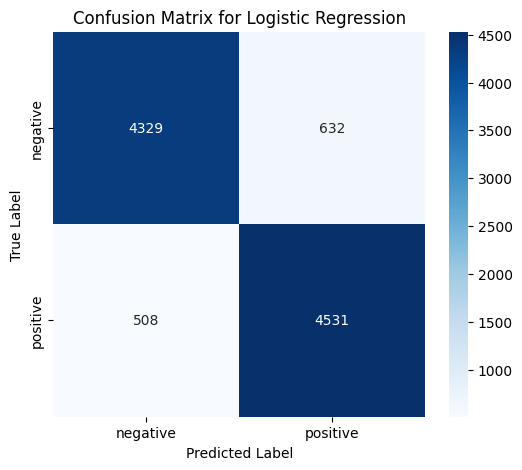


--- Multinomial Naive Bayes Performance ---
Accuracy: 0.8210
Precision: 0.8246
Recall: 0.8190
F1-Score: 0.8218

Classification Report:
              precision    recall  f1-score   support

    negative       0.82      0.82      0.82      4961
    positive       0.82      0.82      0.82      5039

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000


Confusion Matrix:
[[4083  878]
 [ 912 4127]]


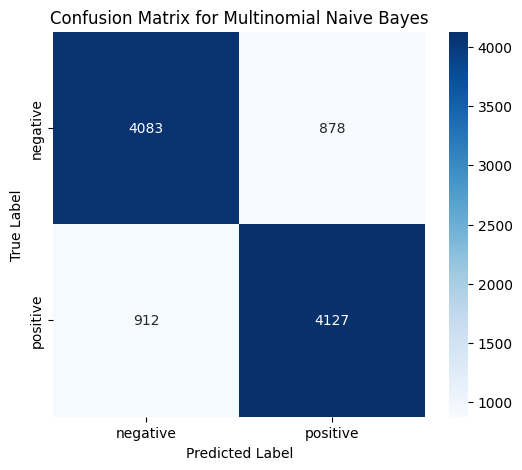


--- Linear SVM Performance ---
Accuracy: 0.8823
Precision: 0.8750
Recall: 0.8942
F1-Score: 0.8845

Classification Report:
              precision    recall  f1-score   support

    negative       0.89      0.87      0.88      4961
    positive       0.87      0.89      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000


Confusion Matrix:
[[4317  644]
 [ 533 4506]]


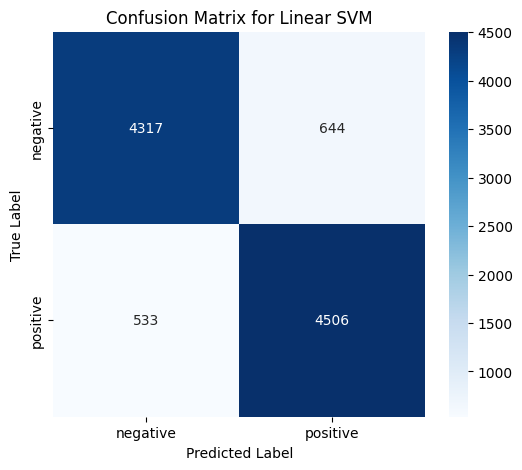


--- Random Forest Performance ---
Accuracy: 0.8491
Precision: 0.8564
Recall: 0.8416
F1-Score: 0.8490

Classification Report:
              precision    recall  f1-score   support

    negative       0.84      0.86      0.85      4961
    positive       0.86      0.84      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000


Confusion Matrix:
[[4250  711]
 [ 798 4241]]


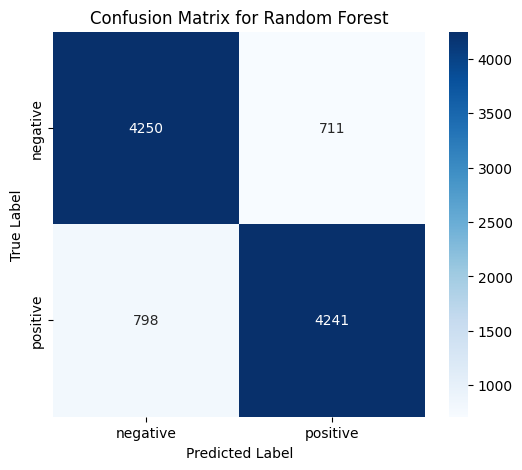

In [ ]:
# List to store performance metrics for each model
all_model_results = []

for model_name, model in trained_models.items():
    result = evaluate_model(model, X_test, y_test, model_name)
    all_model_results.append(result)


In [ ]:
print("\n Summary of All Model Performances")
results_df = pd.DataFrame(all_model_results)
print(results_df.round(4))



 Summary of All Model Performances
                     Model  Accuracy  Precision  Recall  F1-Score
0      Logistic Regression    0.8860     0.8776  0.8992    0.8883
1  Multinomial Naive Bayes    0.8210     0.8246  0.8190    0.8218
2               Linear SVM    0.8823     0.8750  0.8942    0.8845
3            Random Forest    0.8491     0.8564  0.8416    0.8490


## <font color="brown"> Key findings & Insights:

1. The dataset is well balanced with an equal number of positive and negative reviews.
2.The text preprocessing steps (lowercasing, HTML tag removal, punctuation/special character/number removal, tokenization, stop word removal, and lemmatization) made it suitable for feature extraction and helped reduce noise and improve the signal for sentiment detection
3. TF-IDF effectively captures the importance of words within reviews relative to the entire corpus.
4.The combined approach of using TF-IDF vectorization along with simple textual features (word count, character count, average word length) proved effective.
5.Among the four tested machine learning models (Logistic Regression, Multinomial Naive Bayes, Linear SVM, and Random Forest), Logistic Regression consistently demonstrated the highest overall performance.
6. Logistic Classification achieved the highest F1-Score (0.8883) and Accuracy (0.8860), indicating its capability in correctly classifying both positive and negative sentiments.
7. Linear SVM was a very close second in performance (F1-Score: 0.8845).
8. Random Forest performed very well but slightly less effectively than Logistic Regression and Linear SVM (F1-Score: 0.8490).
9. Multinomial Naive Bayes had the lowest performance among the evaluated models (F1-Score: 0.8218).
10.  The strong performance of linear models (Logistic Regression and Linear SVM) when applied to TF-IDF vectorized text features suggests that these models despite their simplicity can effectively learn linear decision boundaries in a high-dimesional text features.

Video Link :
https://drive.google.com/file/d/1HCqk6-SvqwC9QPtc4euw-UyKAGNhHb0e/view?usp=sharing